In [8]:
using Plots
using SparseArrays
using ControlSystems
using OSQP
using ForwardDiff
using LinearAlgebra


In [2]:
# Implement a trajectory tracking MPC
n_points = 1000
T_final = 1.0
t = LinRange(0,T_final,n_points)
trajectory = [cos.(2 * pi * t) sin.(2 * pi * t)]
box_width = 0.75
constraint_x = [-box_width * ones(n_points);LinRange(-box_width, box_width, n_points); box_width * ones(n_points); LinRange(-box_width, box_width, n_points)]
constraint_y = [LinRange(-box_width, box_width, n_points); box_width * ones(n_points); LinRange(-box_width, box_width, n_points);-box_width * ones(n_points)]
x_target = trajectory[:,1]
y_target = trajectory[:,2]

1000-element Vector{Float64}:
  0.0
  0.006289433316067751
  0.012578617838741058
  0.01886730478446709
  0.025155245389375847
  0.0314421909191206
  0.03772789267871718
  0.04401210202238166
  0.05029457036336618
  0.056575049183792345
  ⋮
 -0.05029457036336704
 -0.04401210202238122
 -0.03772789267871721
 -0.031442190919121114
 -0.02515524538937595
 -0.018867304784467676
 -0.012578617838741233
 -0.006289433316067516
 -2.4492935982947064e-16

In [3]:
# Dynamics
g = 9.81
m = 1
l = 0.3
J = 0.2 *m*l*l
h = 0.01

u_min = [0.2*m*g; 0.2*m*g]
u_max = [0.6*m*g; 0.6*m*g]
function dynamics(x, u)
    ddx = (u[1]+u[2])/m * sin(x[3])
    ddz = (u[1]+u[2])/m * cos(x[3]) - g
    ddtheta = (u[2]-u[1])*l / (sqrt(2) * J)
    return [x[4:6]; ddx; ddz; ddtheta]
end

dynamics (generic function with 1 method)

In [4]:
function runge_kutta_4(f, x, u)
    k1 = f(x, u)
    k2 = f(x + h/2 * k1, u)
    k3 = f(x + h/2 * k2, u)
    k4 = f(x + h * k3, u)
    return x + h/6 * (k1 + 2*k2 + 2*k3 + k4)
end


runge_kutta_4 (generic function with 1 method)

In [6]:
x_hover = zeros(6)
u_hover = [0.5 * m * g; 0.5 * m * g]

A = ForwardDiff.jacobian(x -> runge_kutta_4(dynamics, x, u_hover), x_hover)
B = ForwardDiff.jacobian(u -> runge_kutta_4(dynamics, x_hover, u), u_hover)
runge_kutta_4(dynamics, x_hover, u_hover)

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [7]:
Nx = 6
Nu = 2
Tfinal = 10.0
Nt = Int(Tfinal/h) + 1
t_hist = Array(range(0, h*(Nt-1), step=h))

1001-element Vector{Float64}:
  0.0
  0.01
  0.02
  0.03
  0.04
  0.05
  0.06
  0.07
  0.08
  0.09
  ⋮
  9.92
  9.93
  9.94
  9.95
  9.96
  9.97
  9.98
  9.99
 10.0

In [9]:
Q = Array(1.0 * I(Nx))
Q[3:6, 3:6] .= 0.0
R = Array(0.1 * I(Nu))
Q_final = Array(1.0 * I(Nx))
Q_final[3:6, 3:6] .= 0.0

4×4 view(::Matrix{Float64}, 3:6, 3:6) with eltype Float64:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [10]:
function cost(x_hist, u_hist)
    cost = 0.5 *x_hist[:,end]'*Q_final*x_hist[:,end]
    for i in 1:size(x_hist,2)-1
        cost += 0.5 *x_hist[:,i]'*Q*x_hist[:,i] + 0.5 *u_hist[:,i]'*R*u_hist[:,i]
    end
    return cost
end

cost (generic function with 1 method)

In [11]:
P = dare(A,B,Q,R)

6×6 Matrix{Float64}:
 55.3091        7.18286e-12  23.653        …   3.89203e-12  1.89859
  7.18286e-12  67.3759        5.93288e-12     22.3607       5.54947e-13
 23.653         5.93288e-12  24.6383           3.23122e-12  2.79641
 15.019         3.09735e-12  11.0642           1.65543e-12  1.04041
  3.89203e-12  22.3607        3.23122e-12     14.9539       3.07415e-13
  1.89859       5.54947e-13   2.79641      …   3.07415e-13  0.448783

In [151]:
Nh = 30
U = kron(Diagonal(I, Nh), [I zeros(Nu,Nx)])
X = kron(Diagonal(I, Nh), [zeros(2,Nu) I zeros(2, Nx-2)])
Theta = kron(Diagonal(I, Nh), [0 0 0 0 1 0 0 0])
H = sparse([kron(Diagonal(I,Nh-1),[R zeros(Nu,Nx); zeros(Nx,Nu) Q]) zeros((Nx+Nu)*(Nh-1), Nx+Nu); zeros(Nx+Nu,(Nx+Nu)*(Nh-1)) [R zeros(Nu,Nx); zeros(Nx,Nu) P]])
b = zeros(Nh*(Nx+Nu))
C = sparse([[B -I zeros(Nx,(Nh-1)*(Nu+Nx))]; zeros(Nx*(Nh-1),Nu) [kron(Diagonal(I,Nh-1), [A B]) zeros((Nh-1)*Nx,Nx)] + [zeros((Nh-1)*Nx,Nx) kron(Diagonal(I,Nh-1),[zeros(Nx,Nu) Diagonal(-I,Nx)])]])

# Optimization problem with box constraints
# D = [C; U; X]
# lb = [zeros(Nx*Nh); kron(ones(Nh),u_min-u_hover); kron(ones(Nh), -box_width * ones(2))]
# ub = [zeros(Nx*Nh); kron(ones(Nh),u_max-u_hover); kron(ones(Nh), box_width * ones(2))]

# Optimization problem without box constraints
D = [C; U;Theta]
lb = [zeros(Nx*Nh); kron(ones(Nh),u_min-u_hover);-0.2*ones(Nh)]
ub = [zeros(Nx*Nh); kron(ones(Nh),u_max-u_hover);0.2*ones(Nh)]

270-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2

In [152]:
function mpc_controller(t, x, x_ref)
    lb[1:6] .= -A*x
    ub[1:6] .= -A*x

    for j = 1:(Nh-1)
        b[(Nu+(j-1)*(Nx+Nu)).+(1:Nx)] .= -Q * x_ref[j,:]
    end
    b[(Nu+(Nh-1)*(Nx+Nu)).+(1:Nx)] .= -P*x_ref[Nh,:]
    
    OSQP.update!(prob, q=b, l=lb, u=ub)

    #Solve QP
    results = OSQP.solve!(prob)
    Δu = results.x[1:Nu]

    return u_hover + Δu
end

mpc_controller (generic function with 1 method)

In [153]:
function closed_loop(x0,controller,N)
    xhist = zeros(length(x0),N)
    u0 = controller(1,x0)
    uhist = zeros(length(u0),N-1)
    uhist[:,1] .= u0
    xhist[:,1] .= x0
    for k = 1:(N-1)
        uk = controller(k,xhist[:,k])
        uhist[:,k] = max.(min.(u_max, uk), u_min) #enforce control limits
        xhist[:,k+1] .= runge_kutta_4(dynamics, xhist[:,k],uhist[:,k])
    end
    return xhist, uhist
end

closed_loop (generic function with 1 method)

In [154]:
prob = OSQP.Model()
OSQP.setup!(prob; P=H, q=b, A=D, l=lb, u=ub, eps_abs=1e-8, eps_rel=1e-8, polish=1, verbose=false)
x_ref= [0.0; 0.0; 0; 0; 0; 0]
function dynmaic_ref(t)
    trajectory = zeros(Nh, Nx)
    period = 1
    hold = 15
    for i = 1:Nh
        # trajectory[i,:] = [cos(2*pi/period*(t+(i-1)*h) + pi/2); sin(2*pi/period*(t+(i-1)*h) + pi/2); 0; 0; 0; 0]
        trajectory[i,:] = [0.0; 1.0; 0; 0; 0; 0]
        trajectory[i,:] = [cos(2*pi/period*(t+(floor((i-1)/hold))*h) + pi/2); sin(2*pi/period*(t+(floor((i-1)/hold))*h) + pi/2); 0; 0; 0; 0]
    end
    return trajectory
end
x0 = [0.0; 0.8; 0.0; 0; 0; 0]
xhist2, uhist2 = closed_loop(x0, (t,x)->mpc_controller(t,x,dynmaic_ref(t)), Nt);
points = xhist2[1:2,:]

2×1001 Matrix{Float64}:
 0.0  -1.37384e-8  -2.17737e-7  …  -0.062326  -0.062326  -0.062326
 0.8   0.800044     0.800173        0.998112   0.998112   0.998112

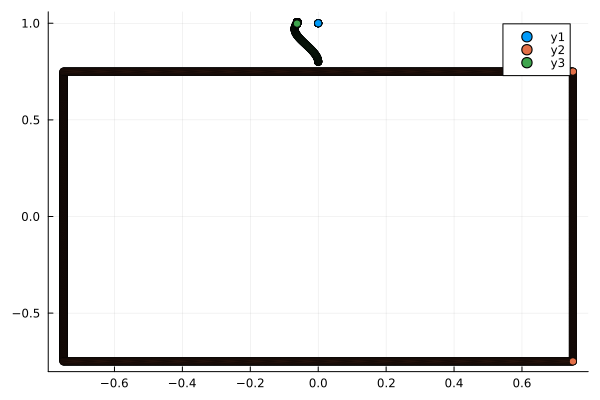

In [155]:
target = dynmaic_ref(0)
scatter(target[:,1], target[:,2])
scatter!(constraint_x, constraint_y)
scatter!(points[1,:], points[2,:])



In [147]:
target

30×6 Matrix{Float64}:
  6.12323e-17  1.0       0.0  0.0  0.0  0.0
  6.12323e-17  1.0       0.0  0.0  0.0  0.0
  6.12323e-17  1.0       0.0  0.0  0.0  0.0
  6.12323e-17  1.0       0.0  0.0  0.0  0.0
  6.12323e-17  1.0       0.0  0.0  0.0  0.0
  6.12323e-17  1.0       0.0  0.0  0.0  0.0
  6.12323e-17  1.0       0.0  0.0  0.0  0.0
  6.12323e-17  1.0       0.0  0.0  0.0  0.0
  6.12323e-17  1.0       0.0  0.0  0.0  0.0
  6.12323e-17  1.0       0.0  0.0  0.0  0.0
  ⋮                                     ⋮
 -0.0627905    0.998027  0.0  0.0  0.0  0.0
 -0.0627905    0.998027  0.0  0.0  0.0  0.0
 -0.0627905    0.998027  0.0  0.0  0.0  0.0
 -0.0627905    0.998027  0.0  0.0  0.0  0.0
 -0.0627905    0.998027  0.0  0.0  0.0  0.0
 -0.0627905    0.998027  0.0  0.0  0.0  0.0
 -0.0627905    0.998027  0.0  0.0  0.0  0.0
 -0.0627905    0.998027  0.0  0.0  0.0  0.0
 -0.0627905    0.998027  0.0  0.0  0.0  0.0